# HW4 q3, q4
### Import libraries

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import torch
import torch.nn as nn

### Neural Networks, SVM and visualization functions

In [2]:
sigmoid = 'sigmoid'
tanh = 'tanh'
relu = 'relu'
identity = 'identity'

module_dic = {
    sigmoid: nn.Sigmoid,
    tanh: nn.Tanh,
    relu: nn.ReLU,
    identity: nn.Identity
}

def build_nn(sl, activation):
    """
    Build an untrained neural network:
        sl: number of nodes in each layer
        activations: the activation function of each layer
    This function returns the initialized model.
    """
    layers = []
    if len(sl) == len(activation) + 1:
        for i in range(0, len(sl) - 1):
            from_dim = sl[i]
            to_dim = sl[i + 1]
            acti_func = activation[i]
            layers.append(nn.Linear(from_dim, to_dim))
            if acti_func in module_dic:
                layers.append(module_dic[acti_func]())
            else:
                raise ValueError(
                    """
                    activation function not supported!
                    Supported function: {}
                    Your function: {} on layer {}
                    """.format(module_dic.keys, acti_func, i + 1))
        return nn.Sequential(*layers)
    else:
        raise ValueError(
            """
            The number of layer and the activation function doesn't match! (layer = activation + 1)
            number of layer:{}
            number of activation function:{}
            """.format(len(sl), len(activation))
        )
        

def train_nn(model, x_trn, y_trn, epoches = 20, mini_batch=100, learning_rate=0.001):
    """
    Train the given model with given dataset.
        model: the nn needs training
        x_trn, y_trn: training data in torch.tensor format
        epoches, mini_batch, learning_rate: hyperparameters
    This function returns the trained model.
    """
    n = len(x_trn)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epoches):
        for i in range((n - 1) // mini_batch + 1):
            start_i = i * mini_batch
            end_i = start_i + mini_batch
            xb = x_trn[start_i:end_i]
            yb = y_trn[start_i:end_i]
            pred = model(xb)
            loss = criterion(pred, yb)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return model


def test_nn(model, x_tst, y_tst):
    """
    Test the model with given test dataset.
        model: the model need testing
        x_tst, y_tst: testing dataset
    Returns the accuracy rate and the prediction on test data.
    """
    _, predi = torch.max(model(x_tst), 1)
    accuracy = 1 - (torch.abs(y_tst - predi).sum().float() / len(predi))
    predi = torch.Tensor.numpy(predi * 2 - 1)
    return accuracy.data, predi


def get_param(model):
    """
    This function returns the trained parameter of the model.
    """
    return list(model.parameters())
    
    
def rbf_svm(x, y, gamma = 0.1):
    clf = svm.SVC(kernel='rbf', gamma=gamma)
    clf.fit(x, y)
    return clf


def data_plot(point, label, title):
    df = pd.DataFrame(np.concatenate([point, np.array([label]).T], axis=1),
                      columns=['x1', 'x2', 'class'])
    minus_pt = df[df['class'] == -1]
    one_pt = df[df['class'] == 1]
    minus_px, minus_py = minus_pt["x1"], minus_pt["x2"]
    one_px, one_py = one_pt["x1"], one_pt["x2"]
    plt.scatter(minus_px, minus_py, c="red", label="-1")
    plt.scatter(one_px, one_py, c="blue", label="1")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.title(title)
    plt.show()
    
    
def data_plot_svm(point, label, title):
    df = pd.DataFrame(np.concatenate([point, np.array([label]).T], axis=1),
                      columns=['x1', 'x2', 'class'])
    minus_pt = df[df['class'] == -1]
    one_pt = df[df['class'] == 1]
    minus_px, minus_py = minus_pt["x1"], minus_pt["x2"]
    one_px, one_py = one_pt["x1"], one_pt["x2"]
    plt.scatter(minus_px, minus_py, marker='s', label="-1")
    plt.scatter(one_px, one_py, marker='o', label="1")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.title(title)
    plt.show()

I have four functions relating to the nn:

**build_nn, train_nn, test_nn, get_param**

These functions build, train, test and get the parameters of the nn. See comments for detailed information.

### Load the data

In [3]:
data = sio.loadmat('./data/hw04_data.mat')
data.pop('__header__')
data.pop('__version__')
data.pop('__globals__')
x_trn = data["X_trn"]
y_trn = data["y_trn"]
x_tst = data["X_tst"]
y_tst = data["y_tst"]

### Plot the data

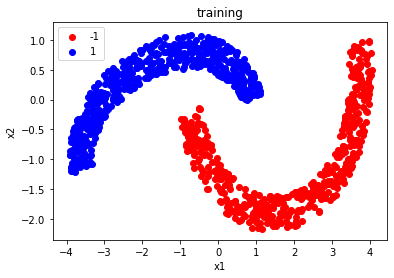

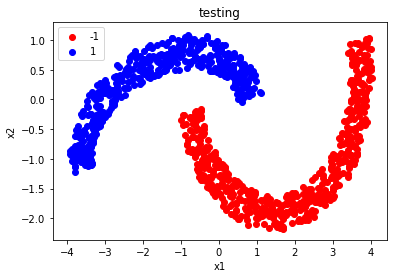

In [4]:

data_plot(x_trn, y_trn.T[0], "training")
data_plot(x_tst, y_tst.T[0], "testing")

From the plot, we can conclude that it is not linearly seperatable.

### rbf svm results:

training score on rbf svm: 1.0
testing score on rbf svm: 1.0


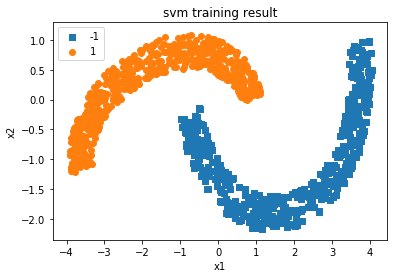

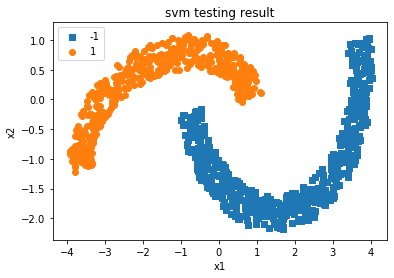

In [5]:
svm_result = rbf_svm(x_trn, y_trn.T[0])
trn_score = svm_result.score(x_trn, y_trn.T[0])
tst_score = svm_result.score(x_tst, y_tst.T[0])
print("training score on rbf svm: {}".format(trn_score))
print("testing score on rbf svm: {}".format(tst_score))
trn_predict_svm = svm_result.predict(x_trn)
tst_predict_svm = svm_result.predict(x_tst)
# print(trn_predict_svm)
data_plot_svm(x_trn, trn_predict_svm, "svm training result")
data_plot_svm(x_tst, tst_predict_svm, "svm testing result")

### Transfer data to tensor format so that pytorch can read it.

The y of the data is modified during input since cross entropy loss require y to be non-negative integers.

We transfer y back during the data visualization.

In [6]:
x_trn_tensor = torch.tensor(x_trn).float()
y_trn_tensor = torch.tensor(y_trn.squeeze() + 1 / 2).long()
x_tst_tensor = torch.tensor(x_tst).float()
y_tst_tensor = torch.tensor(y_tst.squeeze() + 1 / 2).long()

In [7]:
def training(activation_list, hidden_layer, xtrn, ytrn, xtst, ytst, epoches=[200, 200, 200], lr=[0.1, 0.1, 0.1]):
    for id, n in enumerate([10, 30, 50]):
        layer_list = [2] +[n for i in range(hidden_layer)] + [2]
        model = build_nn(layer_list, activation_list)
        model = train_nn(model, xtrn, ytrn, epoches = epoches[id], learning_rate=lr[id])
        acc_trn, model_y_trn = test_nn(model, xtrn, ytrn)
        data_plot_svm(xtrn, model_y_trn, "NN: {} hidden layer, {} nodes. Training result".format(hidden_layer, n))
        print("Training Accuracy rate: {} NN with {} hidden layer, {} nodes.".format(acc_trn, hidden_layer, n))
        acc_tst, model_y_tst =test_nn(model, xtst, ytst)
        data_plot_svm(xtst, model_y_tst, "NN: {} hidden layer, {} nodes. Training result".format(hidden_layer, n))
        print("Testing Accuracy rate: {} NN with {} hidden layer, {} nodes.".format(acc_tst, hidden_layer, n))

### 1 hidden layer:

#### Activation Function: relu, sigmoid

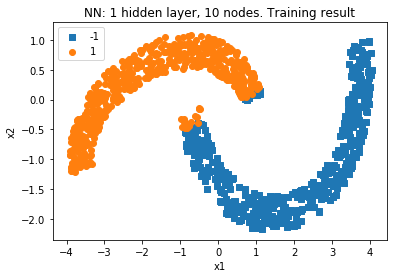

Training Accuracy rate: 0.9739999771118164 NN with 1 hidden layer, 10 nodes.


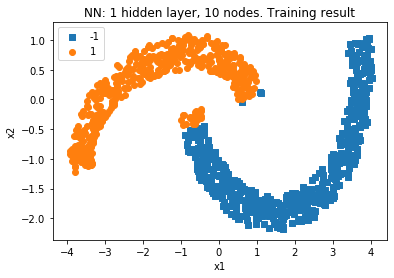

Testing Accuracy rate: 0.9769999980926514 NN with 1 hidden layer, 10 nodes.


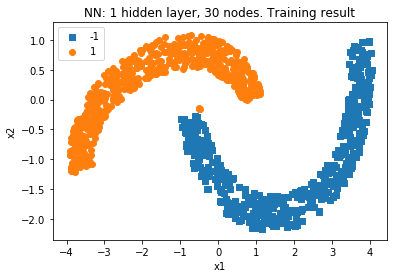

Training Accuracy rate: 0.996999979019165 NN with 1 hidden layer, 30 nodes.


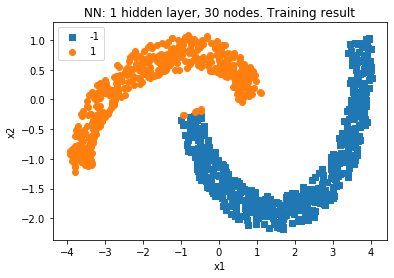

Testing Accuracy rate: 0.9940000176429749 NN with 1 hidden layer, 30 nodes.


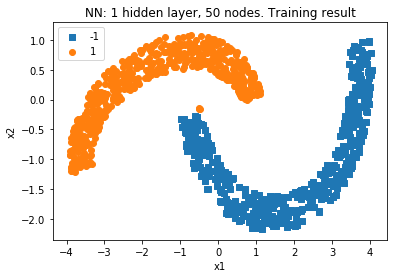

Training Accuracy rate: 0.996999979019165 NN with 1 hidden layer, 50 nodes.


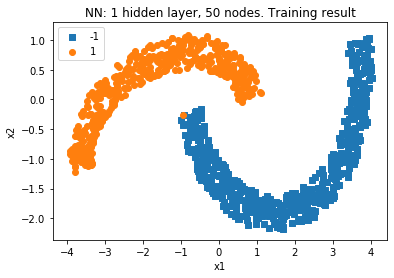

Testing Accuracy rate: 0.9990000128746033 NN with 1 hidden layer, 50 nodes.


In [8]:
training([relu, sigmoid], 1, x_trn_tensor, y_trn_tensor, x_tst_tensor, y_tst_tensor)

### 2 hidden layer:

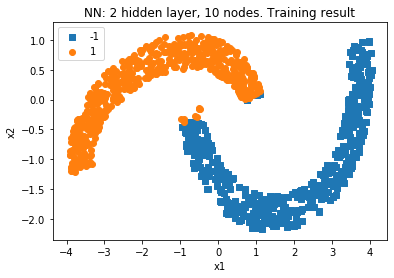

Training Accuracy rate: 0.9890000224113464 NN with 2 hidden layer, 10 nodes.


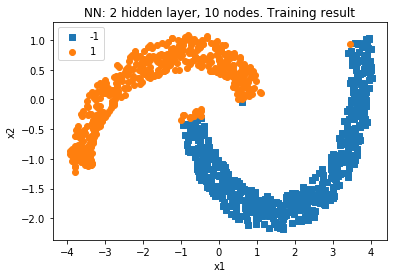

Testing Accuracy rate: 0.9850000143051147 NN with 2 hidden layer, 10 nodes.


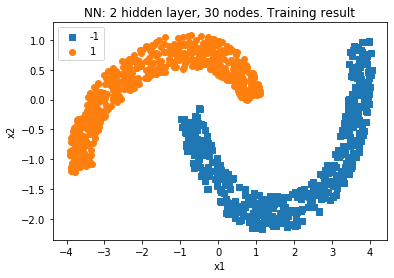

Training Accuracy rate: 1.0 NN with 2 hidden layer, 30 nodes.


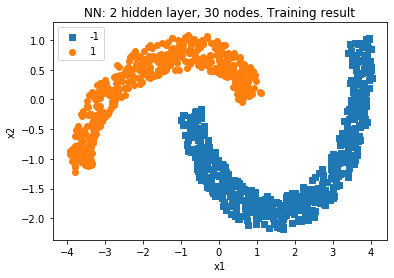

Testing Accuracy rate: 1.0 NN with 2 hidden layer, 30 nodes.


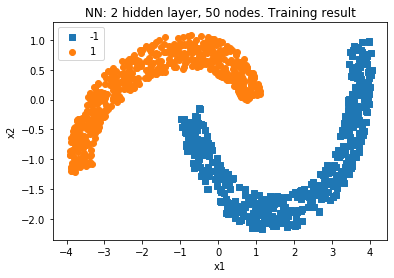

Training Accuracy rate: 1.0 NN with 2 hidden layer, 50 nodes.


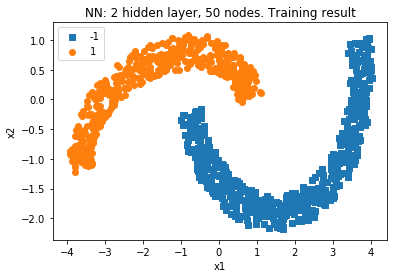

Testing Accuracy rate: 1.0 NN with 2 hidden layer, 50 nodes.


In [9]:
training([relu, relu, sigmoid], 2, x_trn_tensor, y_trn_tensor, x_tst_tensor, y_tst_tensor)